In [41]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor, StackingRegressor
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBRegressor
import warnings
from sklearn.preprocessing import PolynomialFeatures
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_log_error
warnings.filterwarnings('ignore')

# Exploratory Data Analysis (EDA)

In [13]:
def load_data():
    data_dir = '../input/'

    train = pd.read_csv(data_dir + 'train.csv', index_col="id")
    test = pd.read_csv(data_dir + 'test.csv', index_col="id")
    return train, test

In [51]:
train, test = load_data()
train

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
id,,,,,,,,
0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,female,38,166.0,61.0,25.0,102.0,40.6,146.0
...,...,...,...,...,...,...,...,...
749995,male,28,193.0,97.0,30.0,114.0,40.9,230.0
749996,female,64,165.0,63.0,18.0,92.0,40.5,96.0
749997,male,60,162.0,67.0,29.0,113.0,40.9,221.0


In [52]:
train['Sex_encoded'] = train['Sex'].map({'female': 0, 'male': 1})
test['Sex_encoded'] = test['Sex'].map({'female': 0, 'Male': 1})

train.drop('Sex', axis=1, inplace=True)
test.drop('Sex', axis=1, inplace=True)

In [27]:
train.isnull().sum()

Age            0
Height         0
Weight         0
Duration       0
Heart_Rate     0
Body_Temp      0
Calories       0
Sex_encoded    0
dtype: int64

In [75]:
test.to_csv('output/test_clean.csv', index=True)

In [46]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 750000 entries, 0 to 749999
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   Age          750000 non-null  int64   
 1   Height       750000 non-null  float64 
 2   Weight       750000 non-null  float64 
 3   Duration     750000 non-null  float64 
 4   Heart_Rate   750000 non-null  float64 
 5   Body_Temp    750000 non-null  float64 
 6   Calories     750000 non-null  float64 
 7   Sex_encoded  750000 non-null  category
dtypes: category(1), float64(6), int64(1)
memory usage: 46.5 MB


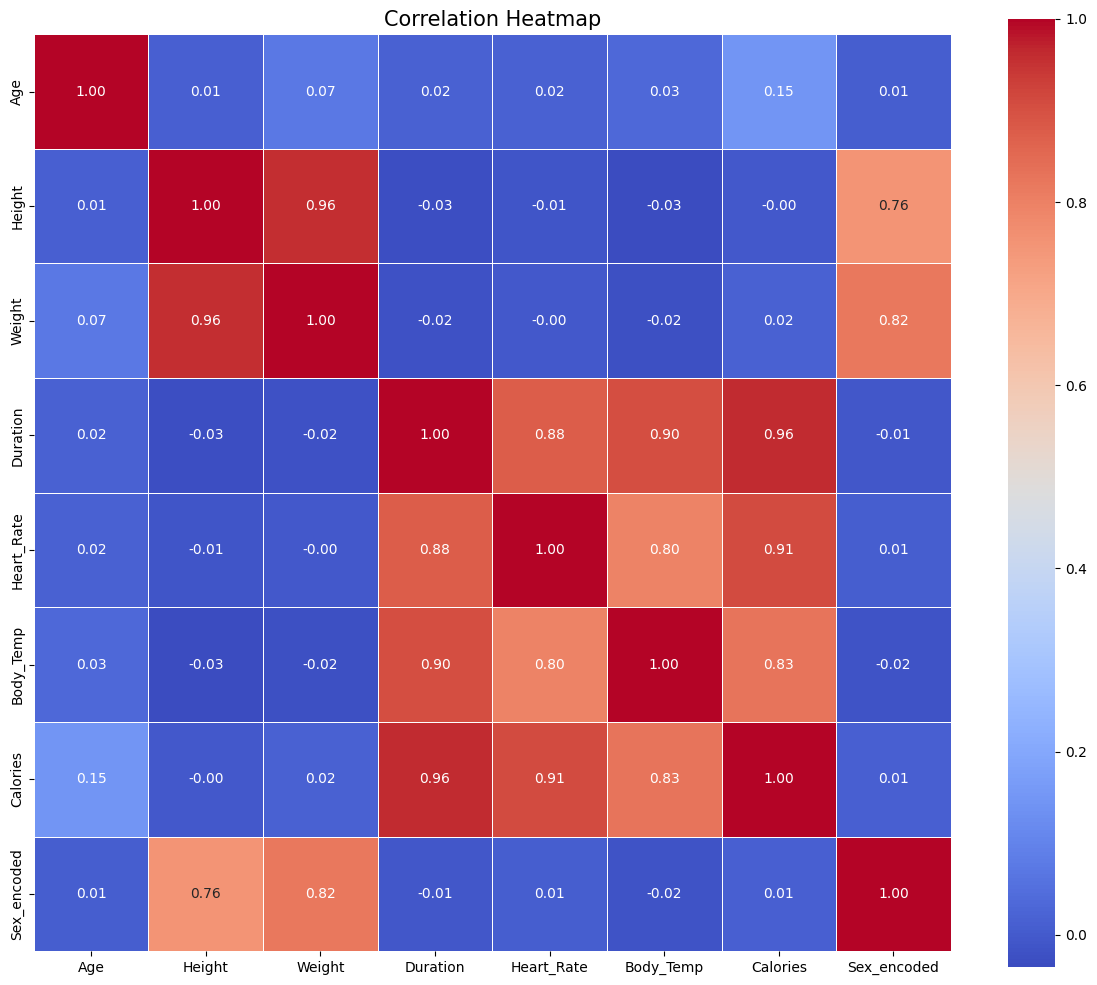

In [32]:
correlation = train.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=0.5)
plt.title('Correlation Heatmap', fontsize=15)
plt.tight_layout()
plt.show()

# Preprocessing

# Feature Engineering

# Data preparation

In [53]:
X_train = train.drop(columns=['Calories'])
y_train = train['Calories']
X_test = test.copy()

# Model Evaluation

In [54]:
catboost_model = CatBoostRegressor(
    iterations=500,
    learning_rate=0.1,
    depth=8,
    l2_leaf_reg=5,
    border_count=128,
    subsample=0.8,
    rsm=0.9,
    random_state=42,
    verbose=0,
    # cat_features=['Sex_encoded']
)

In [65]:

best_model = CatBoostRegressor(
    iterations=1500,
    learning_rate=0.06317649508181446,
    depth=9,
    l2_leaf_reg=0.48022672681163453,
    border_count=176,
    bagging_temperature=0.6608341245724981,
    random_strength=0.8772083475373182,
    subsample=0.9673273228480513,
    colsample_bylevel=0.641906388550445,
    min_data_in_leaf=14,
    verbose=0,
    random_state=42
)


In [42]:
from sklearn.metrics import mean_squared_log_error

def evaluate_model_with_cross_validation(model, X, y, cv=5):
    """
    Evaluate model performance with cross-validation and detailed metrics
    """
    if isinstance(model, CatBoostRegressor):
        cat_features = [i for i, col in enumerate(X.columns) if
                        pd.api.types.is_categorical_dtype(X[col]) or
                        pd.api.types.is_object_dtype(X[col]) or
                        pd.api.types.is_bool_dtype(X[col])]

        params = model.get_params()

        # cat_features params
        if 'cat_features' in params:
            if cat_features:
                params['cat_features'] = cat_features
            else:
                del params['cat_features']
        elif cat_features:
            params['cat_features'] = cat_features

        print(f"Using cat_features: {params['cat_features'] if 'cat_features' in params else 'None'}")
        model = CatBoostRegressor(**params)

    cv_preds = cross_val_predict(model, X, y, cv=cv)

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y, cv_preds))
    r2 = r2_score(y, cv_preds)
    mae = mean_absolute_error(y, cv_preds)

    # Calculate RMSLE safely (requires all values >= 0)
    if np.all(y >= 0) and np.all(cv_preds >= 0):
        rmsle = np.sqrt(mean_squared_log_error(y, cv_preds))
    else:
        rmsle = np.nan
        print("Warning: RMSLE not computed due to negative values in predictions or actuals.")

    print(f"Cross-Validation Results (CV={cv}):")
    print(f"RMSE: {rmse:.6f}")
    print(f"R²: {r2:.6f}")
    print(f"MAE: {mae:.6f}")
    print(f"RMSLE: {rmsle:.6f}" if not np.isnan(rmsle) else "RMSLE: NaN (invalid due to negative values)")

    # Visualize results
    plt.figure(figsize=(14, 5))

    # Actual vs Predicted
    plt.subplot(1, 2, 1)
    plt.scatter(y, cv_preds, alpha=0.5)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Actual vs Predicted')

    # Residuals
    plt.subplot(1, 2, 2)
    residuals = y - cv_preds
    plt.scatter(cv_preds, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted')
    plt.ylabel('Residuals')
    plt.title('Residuals Plot')

    plt.tight_layout()
    plt.show()

    return rmse, r2, mae, rmsle


Using cat_features: None
Cross-Validation Results (CV=5):
RMSE: 3.547454
R²: 0.996768
MAE: 2.123642
RMSLE: 0.061700


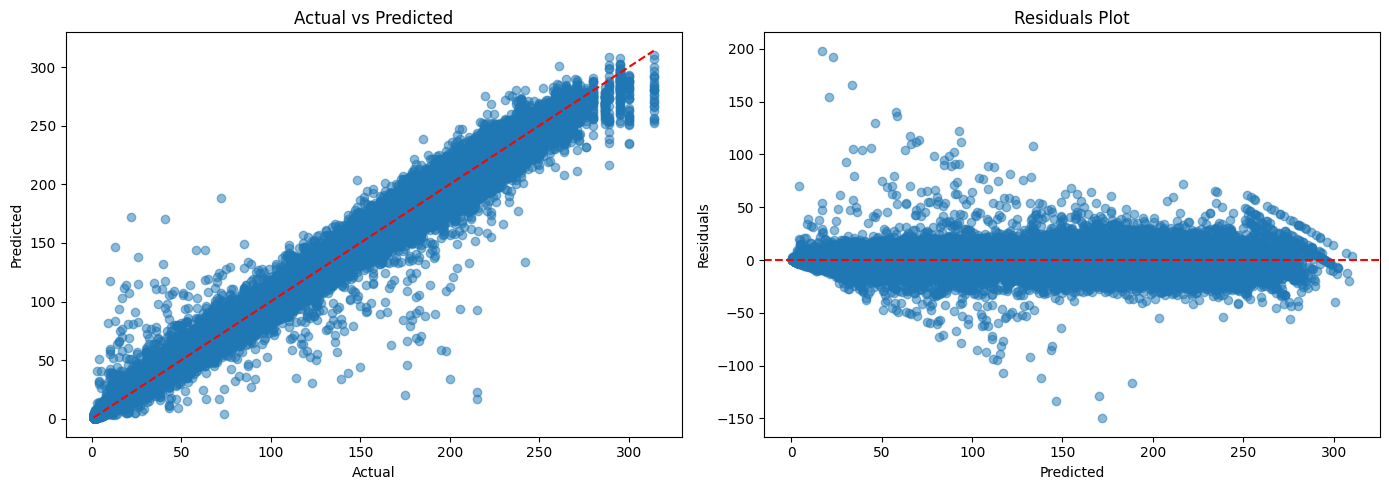

In [55]:
rmse, rmsle, r2, mae = evaluate_model_with_cross_validation(catboost_model, X_train, y_train, cv=5)

Using cat_features: None
Cross-Validation Results (CV=5):
RMSE: 3.541669
R²: 0.996778
MAE: 2.105761
RMSLE: 0.060382


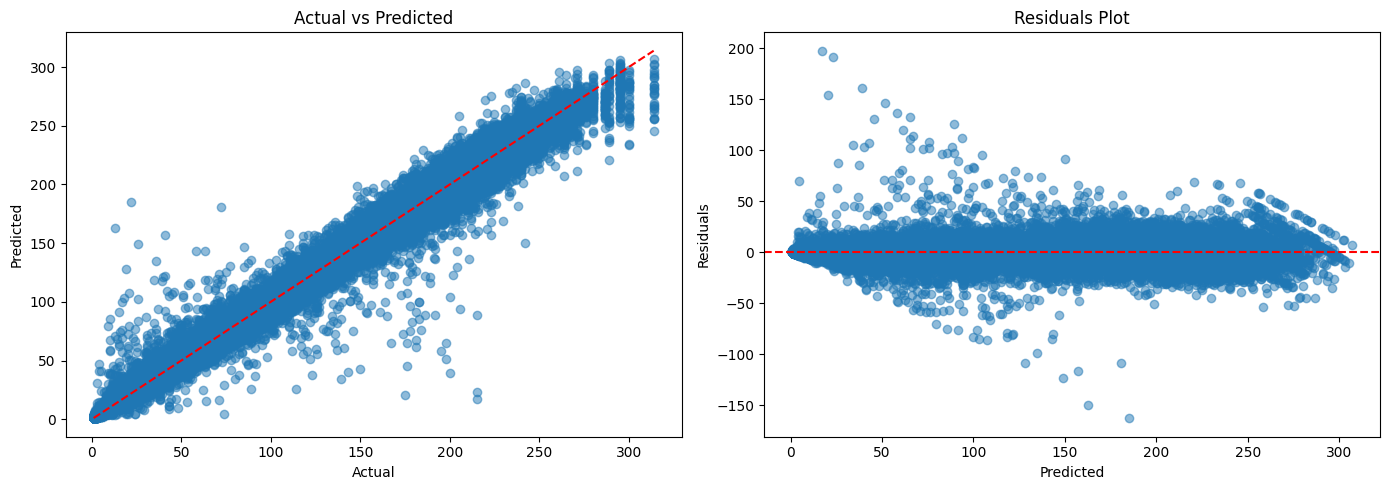

In [66]:
rmse, rmsle, r2, mae = evaluate_model_with_cross_validation(best_model, X_train, y_train, cv=5)

In [67]:
best_model.fit(X_train, y_train)

In [68]:
predictions = best_model.predict(X_test)

In [69]:
predictions

array([ 29.319493  , 106.08443629,  87.41814265, ...,  73.25348598,
       168.68928165,  73.52072796], shape=(250000,))

# Submission

In [70]:
def make_submisson():
    output = pd.DataFrame({'id': X_test.index, 'hydrostatic_pressure': predictions})
    output.to_csv('output/submission2.csv', index=False)
    print("Your submission was successfully saved!")

In [71]:
make_submisson()

Your submission was successfully saved!
